# Probabilistic Demand Forecasting Using Global Quantile Models

This notebook trained global probabilistic forecasting models
to estimate future demand distributions rather than single
point predictions.

Quantile-based forecasting was used to explicitly model
uncertainty, which is critical for downstream inventory
and risk-aware decision making.


In [5]:
# Imported core libraries for modeling and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)


## Loading Feature-Engineered Dataset

The dataset generated in the causal feature engineering step
was loaded here to ensure consistency across models.


In [6]:
# Loaded processed feature-engineered dataset
data = pd.read_csv("../data/processed/feature_engineered_data.csv")

# Verified dataset structure
data.head()


,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,event_name_1,snap_CA,snap_TX,snap_WI,sku_store,sell_price,lag_7,lag_14,lag_28,price_change,rolling_mean_7,rolling_std_7,event_flag,snap,week,month,year,intermittent_flag
0,FOODS_2_166_CA_1_validation,FOODS_2_166,FOODS_2,FOODS,CA_1,CA,d_47,1,2011-03-16,11107,LentWeek2,0,0,0,FOODS_2_166_CA_1,2.34,0.0,1.0,3.0,0.0,1.142857,1.772811,1,0,11,3,2011,0
1,FOODS_2_382_CA_1_validation,FOODS_2_382,FOODS_2,FOODS,CA_1,CA,d_47,0,2011-03-16,11107,LentWeek2,0,0,0,FOODS_2_382_CA_1,3.25,2.0,0.0,1.0,0.0,0.714286,0.755929,1,0,11,3,2011,1
2,FOODS_3_096_CA_1_validation,FOODS_3_096,FOODS_3,FOODS,CA_1,CA,d_47,0,2011-03-16,11107,LentWeek2,0,0,0,FOODS_3_096_CA_1,4.38,1.0,1.0,0.0,0.0,0.714286,0.755929,1,0,11,3,2011,1
3,HOBBIES_1_178_CA_2_validation,HOBBIES_1_178,HOBBIES_1,HOBBIES,CA_2,CA,d_47,2,2011-03-16,11107,LentWeek2,0,0,0,HOBBIES_1_178_CA_2,0.42,1.0,0.0,0.0,0.0,0.714286,0.755929,1,0,11,3,2011,1
4,HOBBIES_2_116_CA_2_validation,HOBBIES_2_116,HOBBIES_2,HOBBIES,CA_2,CA,d_47,0,2011-03-16,11107,LentWeek2,0,0,0,HOBBIES_2_116_CA_2,2.97,0.0,0.0,0.0,0.0,0.571429,0.786796,1,0,11,3,2011,1


## Train–Test Split Strategy

A time-aware split was used instead of random sampling
to avoid look-ahead bias.

The most recent observations were reserved for testing,
simulating a real forecasting scenario.


In [8]:
# Converted date column to datetime
data["date"] = pd.to_datetime(data["date"])

# Sorted data chronologically
data = data.sort_values("date")

# Defined forecast horizon
forecast_horizon = 28

# Split into train and test based on time
train_data = data[data["date"] <= data["date"].max() - pd.Timedelta(days=forecast_horizon)]
test_data  = data[data["date"] >  data["date"].max() - pd.Timedelta(days=forecast_horizon)]

train_data.shape, test_data.shape


((2160, 28), (478, 28))

## Feature and Target Selection

Only features that would be available at prediction time
were included to avoid data leakage.


In [9]:
feature_cols = [
    "lag_7", "lag_14", "lag_28",
    "rolling_mean_7", "rolling_std_7",
    "price_change",
    "event_flag", "snap",
    "week", "month"
]

X_train = train_data[feature_cols]
y_train = train_data["demand"]

X_test = test_data[feature_cols]
y_test = test_data["demand"]


## Why Quantile Regression?

Traditional models predict the conditional mean.
However, operational decisions require understanding
the full distribution of possible outcomes.

Quantile regression was used to estimate:
- Lower bound (p10)
- Median forecast (p50)
- Upper bound (p90)


## Training Global Quantile Models

A single global LightGBM model was trained per quantile.
This allowed shared learning across thousands of
related time series.


In [11]:
quantiles = [0.1, 0.5, 0.9]
models = {}
predictions = {}

for q in quantiles:
    model = GradientBoostingRegressor(
        loss="quantile",
        alpha=q,
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )

    model.fit(X_train, y_train)
    models[q] = model
    predictions[q] = model.predict(X_test)

## Forecast Visualization

Forecast uncertainty was visualized using prediction
intervals around the median forecast.


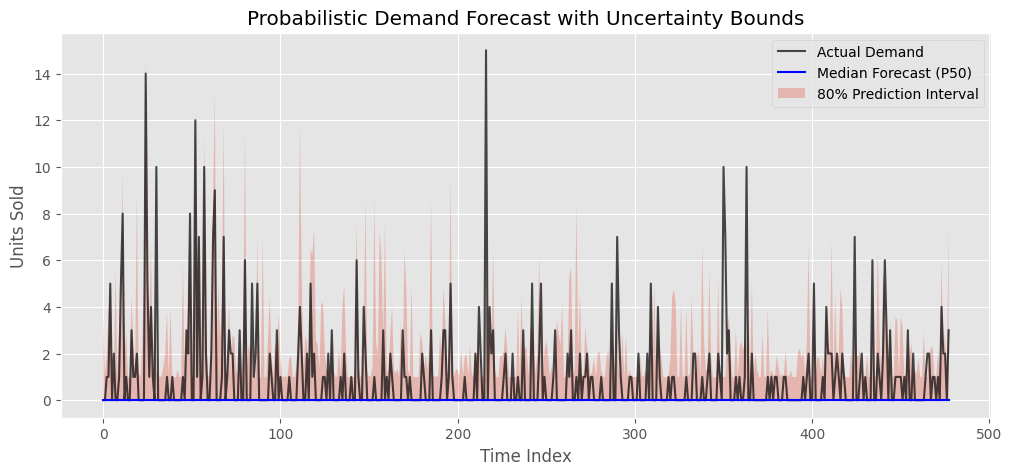

In [12]:
plt.figure(figsize=(12, 5))

plt.plot(y_test.values, label="Actual Demand", color="black", alpha=0.7)
plt.plot(predictions[0.5], label="Median Forecast (P50)", color="blue")

plt.fill_between(
    range(len(y_test)),
    predictions[0.1],
    predictions[0.9],
    alpha=0.3,
    label="80% Prediction Interval"
)

plt.legend()
plt.title("Probabilistic Demand Forecast with Uncertainty Bounds")
plt.xlabel("Time Index")
plt.ylabel("Units Sold")
plt.show()


## Evaluation Metrics

Multiple metrics were used to assess forecast quality,
including point accuracy and uncertainty calibration.


In [13]:
mae = mean_absolute_error(y_test, predictions[0.5])
mae


1.0669456066945606

In [14]:
# Calculated empirical coverage of the prediction interval
coverage = np.mean(
    (y_test >= predictions[0.1]) &
    (y_test <= predictions[0.9])
)

coverage


np.float64(0.8723849372384938)

## Residual Diagnostics

Residual analysis was performed to check for
systematic bias in the median forecast.


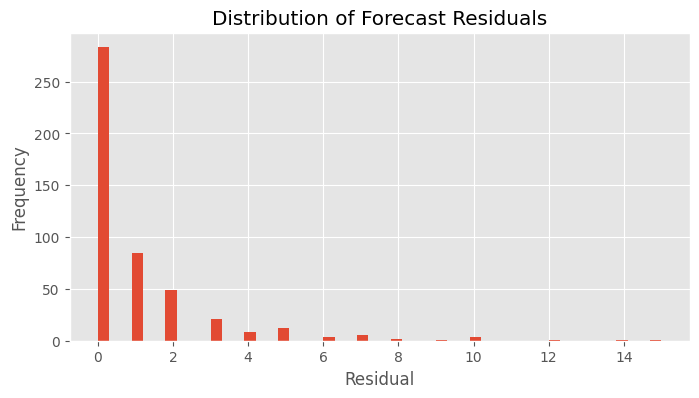

In [15]:
residuals = y_test - predictions[0.5]

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50)
plt.title("Distribution of Forecast Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


## Saving Forecast Outputs

Forecasts were saved to disk for use in hierarchical
reconciliation and inventory optimization.


In [18]:
import os

os.makedirs("../outputs/forecasts", exist_ok=True)


In [19]:
forecast_df = test_data[["date", "sku_store"]].copy()

forecast_df["p10"] = predictions[0.1]
forecast_df["p50"] = predictions[0.5]
forecast_df["p90"] = predictions[0.9]

forecast_df.to_csv(
    "../outputs/forecasts/probabilistic_forecasts.csv",
    index=False
)


## Summary

In this notebook:

- A time-aware train–test split was applied
- Global quantile models were trained using LightGBM
- Demand uncertainty was explicitly modeled
- Prediction intervals were visualized and validated
- Forecast outputs were saved for downstream use

These probabilistic forecasts formed the foundation
for hierarchical reconciliation and inventory optimization.
